# On the Mechanical Cause of the Box Beam's Bifurcation Break

***

In this notebook we demonstrate the mechanical cause of the bifurcation break observed for both the [unreinforced](06_Nonlinear_Buckling_Method_Verification.ipynb) and the [reinforced box beam](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb#nonlinear-buckling-method-verification) under a concentrated bending load applied at the tip.

* [Introduction](#introduction)
* [Unreinforced box beam](#unreinforced)
    * [Setup of the numerical model](#unreinforced-numerical-model)
    * [Linear buckling analysis](#unreinforced-linear-buckling)
    * [Nonlinear analysis](#unreinforced-nonlinear-analysis)
    * [Stress results](#unreinforced-stress-results)
* [Reinforced box beam](#reinforced)
    * [Setup of the numerical model](#reinforced-numerical-model)
    * [Linear buckling analysis](#reinforced-linear-buckling)
    * [Nonlinear analysis](#reinforced-nonlinear-analysis)
    * [Stress results](#reinforced-stress-results)
* [Conclusions](#conclusions)


## Introduction <a name="introduction"></a>

***

We make the hypothesis that the bifurcation break is caused by an asymmetry of the internal loads about the midplane of the top skin, which is a consequence of the global top-down asymmetry introduced by the bending load.

We can observe this in the figure below, where we can see a section of an unreinforced box beam at the front-rear plane of symmetry. The concentrated tip load $P$ causes a deflection of the box beam that brings the top skin under compression and the bottom skin under tension.

In this configuration, the axial stresses in the spars at a given spanwise section must vary from positive to negative along the local height. Also the axial stresses in each skin must have an analogous variation between the local top and bottom plane. However, in this case the variation is between two positive values for the bottom skin and between two negative values for the top skin. As a consequence there is no symmetry of the stresses, and thus of the internal loads, about the midplane of the top skin, which causes the theoretical pitchfork bifurcation to break.

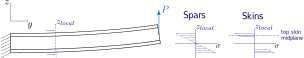

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join('resources', '10_BoxBeamStresses.svg'))

We are going to test this hypothesis on both the unreinforced and the reinforced box beam configurations.

## Unreinforced box beam <a name="unreinforced"></a>

***

### Setup of the numerical model <a name="unreinforced-numerical-model"></a>

We consider an unreinforced box beam with the same geometry and material properties as in our previous notebooks.

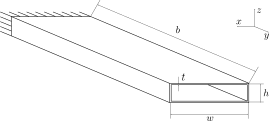

In [2]:
SVG(filename=os.path.join('resources', '04_BoxBeamGeometry.svg'))

In [3]:
AR = 9.   # aspect ratio - 2*b/w (the span of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
b = AR*w/2  # span [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.2f} m\n- span: {b/1e3:.2f} m\n- height: {h/1e3:.2f} m\n- wall thickness: {t:.2f} mm')

Box beam dimensions:
- width: 1.00 m
- span: 4.50 m
- height: 0.20 m
- wall thickness: 4.00 mm


In [4]:
rho = 2780e-12  # density [ton/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio

We create a mesh of quadrilateral elements using the function `mesh_box_with_pyvista` from the `box_beam_utils` module. We prescribe an edge length of 86 mm based on the results of a previous [mesh convergence study](04_Nonlinear_Buckling_Box_Beam.ipynb).

In [5]:
from resources import box_beam_utils

edge_length = 86  # [mm]
unreinforced_box_beam_mesh = box_beam_utils.mesh_box_with_pyvista(width=w, span=b, height=h, edge_length=edge_length)
nodes_coordinates_array = unreinforced_box_beam_mesh.points
nodes_connectivity_matrix = unreinforced_box_beam_mesh.faces.reshape(-1, 5)[:, 1:]

Now we create a base `BDF` object where we define fixed boundary conditions at the root of the box beam.

In [6]:
unreinforced_box_beam_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
print(unreinforced_box_beam_bdf.get_bdf_stats())  # print cards of BDF object

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 1760

bdf.elements: 0
  CQUAD4   : 1728

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Then we apply a concentrated tip load at the center of the tip section as shown below. We use a RBE2 element to connect the nodes along the tip section to the node in the center.

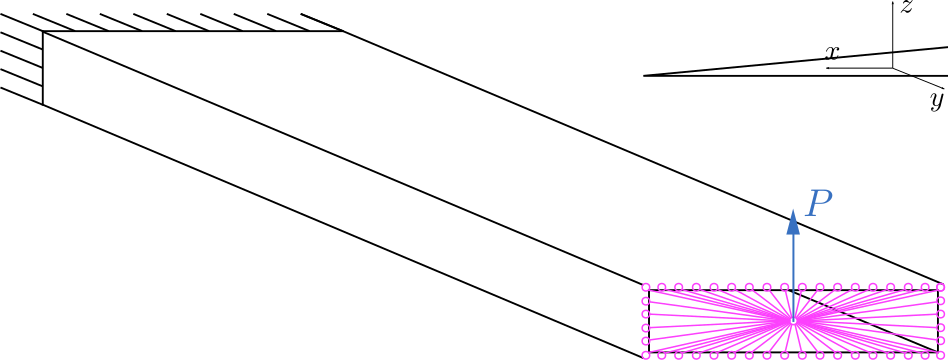

In [7]:
SVG(filename=os.path.join('resources', '04_BoxBeamConcentratedLoad.svg'))

In [8]:
import numpy as np
from resources import pynastran_utils

# Find id of tip nodes
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tolerance = edge_length/100
tip_nodes_ids = nodes_ids[np.abs(nodes_coordinates_array[:,1] - b) < tolerance]

# Add master node of tip section
tip_master_node_id = np.amax(nodes_ids) + 1
unreinforced_box_beam_bdf.add_grid(tip_master_node_id, [w/2, b, 0.])

# Add RBE2 to connect master node with outer nodes of tip rib
rbe2_eid = len(unreinforced_box_beam_bdf.elements) + 1
unreinforced_box_beam_bdf.add_rbe2(eid=rbe2_eid, gn=tip_master_node_id, cm='123456', Gmi=tip_nodes_ids)

# Add concentrated force
force_set_id = 11
force_direction = [0., 0., 1.]
pynastran_utils.add_unitary_force(bdf_object=unreinforced_box_beam_bdf, nodes_ids=[tip_master_node_id], set_id=force_set_id, direction_vector=force_direction)

### Linear buckling analysis <a name="unreinforced-linear-buckling"></a>

We use SOL 105 to calculate the linear buckling load and the corresponding buckling shape, so that we have a reference for the nonlinear analysis.

Buckling load: 1657 N
Buckling mode:


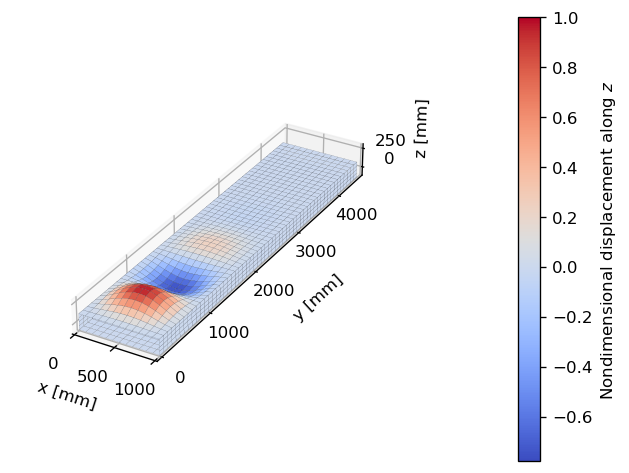

In [9]:
import matplotlib.pyplot as plt

# Run SOL 105 and return OP2 object
analysis_directory_name = '10_On_the_Mechanical_Cause_of_the_Box_Beam_Bifurcation_Break'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
input_name = 'unreinforced_box_beam_linear_buckling'
sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=unreinforced_box_beam_bdf.__deepcopy__({}), static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)  # we pass a deep copy of the BDF object to the function to be able to set up the nonlinear analysis later

# Define function to adjust axes ticks and labels' position
def set_ticks_and_labels_position(axes):
    axes.locator_params(axis='x', nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis='z', nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis='y', which='major', pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis='z', which='major', pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 60  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label

# Print critical buckling load and plot mode
sol_105_buckling_load = sol_105_op2.eigenvectors[2].eigr
print(f'Buckling load: {sol_105_buckling_load:.0f} N')
plt.rcParams['figure.dpi'] = 120  # set default dpi of figures
print(f'Buckling mode:')
_, ax = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=2, displacement_component='tz', colormap='coolwarm')
set_ticks_and_labels_position(ax)
plt.show()

### Nonlinear analysis <a name="unreinforced-nonlinear-analysis"></a>

Now we set up our nonlinear analysis (SOL 106) with the arc-length method using the function `set_up_arc_length_method` from the `pynastran_utils` module. We use the set of parameters obtained from a [previous sensitivity study](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb#nonlinear-analysis-parameters) on the nonlinear analysis parameters.

In [10]:
pynastran_utils.set_up_arc_length_method(bdf_object=unreinforced_box_beam_bdf, ninc=100, eps_p=1e-3, eps_w=1e-7, maxalr=1.1, desiter=5, maxinc=100)  # set up nonlinear analysis with arc-length method

Let's define the magnitude of the applied load as twice the buckling load obtained by SOL 105 and let's create the corresponding subcase. We also add a case control command to store the nonlinear stress results in the op2 file.

In [11]:
# Define applied load magnitude
load_set_id = force_set_id + 1
load_magnitude = sol_105_buckling_load*2
unreinforced_box_beam_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[load_magnitude], load_ids=[force_set_id])

# Create subcase
subcase_id = 1
pynastran_utils.create_static_load_subcase(bdf_object=unreinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=load_set_id)

# Store nonlinear stress results of all elements in the op2 file
unreinforced_box_beam_bdf.case_control_deck.subcases[0].add_result_type('NLSTRESS', 'ALL', ['PLOT'])

We run the analysis and plot the load-displcacement diagram and the final deformation shape.

Nastran job unreinforced_box_beam_nonlinear_analysis.bdf completed
Wall time: 20.0 s


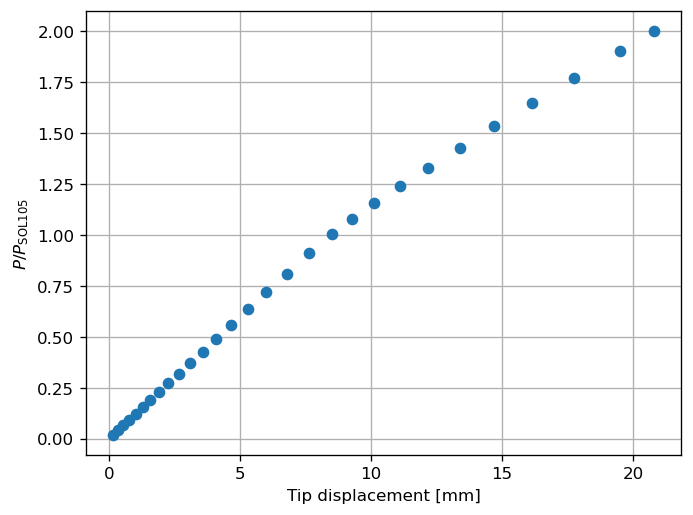

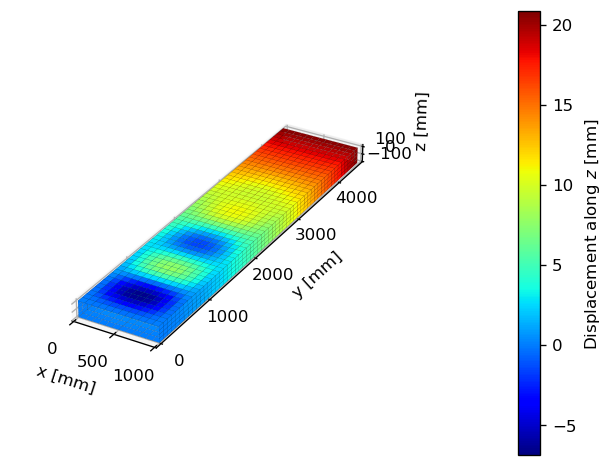

In [12]:
from pyNastran.op2.op2 import read_op2

# Run analysis
input_filename = 'unreinforced_box_beam_nonlinear_analysis'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=unreinforced_box_beam_bdf, filename=input_filename, run_flag=False)

# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)

# Find load and displacement history
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=tip_master_node_id)

# Select translation along z as the load and displacement components to plot
load_component_index = 2
displacement_component_index = 2

# Plot load-displacement diagram
_, ax = plt.subplots()
ax.plot(displacements[1][:,displacement_component_index], loads[1][:, load_component_index]/sol_105_buckling_load, 'o')
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL 105}$')
plt.grid()
plt.show()

# Plot final static deformation
_, ax = pynastran_utils.plot_static_deformation(op2_object=op2_output, subcase_id=subcase_id, displacement_component='tz')
set_ticks_and_labels_position(ax)
plt.show()

As expected we find a change in the slope of the load-dislacement diagram at $P/P_\text{SOL 105}=1$ and a buckled-like shape for the final deformation of the structure.

### Stress results <a name="unreinforced-stress-results"></a>

Now we want to look at the axial stresses in the top skin at a given $y$ location to verify that there is no symmetry about the midplane. We consider the first load increment of the nonlinear analysis, approximately $P/P_\text{SOL 105}=0.02$, because if the symmetry of the internal loads breaks it should do so from the start of the loading process. Since Nastran's stress output is given in terms of the element's local $x$ and $y$ axes, we first need to understand the orientation of the elements' coordinate system with respect to the global one. For this reason we plot all the elements of the top skin and the coordinate system of the first element, where the $x$ axis is colored in red, the $y$ axis is colored in green and the $z$ axis is colored in blue. We only need to look at the coordinate system of one of the elements because the mesh creation process enforces all elements of the same structural part (top skin in this case) to have the same coordinate system as defined by Nastran's convention for CQUAD4 elements.

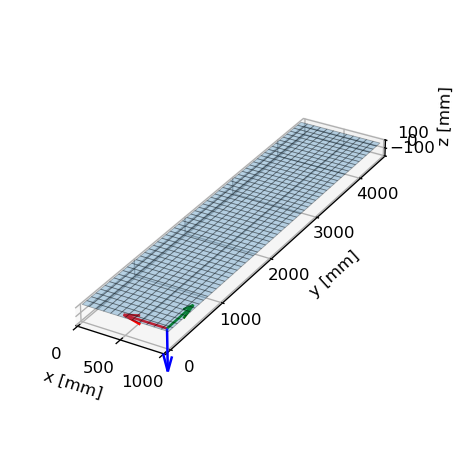

In [13]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Find coordinates of nodes and centroid of all elements
elements_nodes_xyz = np.stack([e.get_node_positions() for e in op2_output.elements.values()], axis=0)
elements_centroid_xyz = np.sum(elements_nodes_xyz, axis=1)/4

# Find nodes coordinates of top skin elements
top_skin_indices = np.where(np.abs(elements_centroid_xyz[:,2] - h/2)<tolerance)[0]  # find indices of elements centroids with z=h/2
top_skin_elements_nodes_xyz = elements_nodes_xyz[top_skin_indices, :, :]

# Find the coordinate system of the first element of the top skin
elements_ids = np.asarray(list(op2_output.elements.keys()))
element_coordinate_system = op2_output.elements[elements_ids[top_skin_indices[0]]].element_coordinate_system()

# Create figure with 3d axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot elements
pc = Poly3DCollection(top_skin_elements_nodes_xyz, linewidths=.5, alpha=.3)
pc.set_edgecolor('k')
ax.add_collection3d(pc)

# Plot element coordinate system
arrow_length = 500
arrowhead_length_ratio = .4
ax.quiver(element_coordinate_system[1][0], element_coordinate_system[1][1], element_coordinate_system[1][2],
               element_coordinate_system[2][0], element_coordinate_system[2][1], element_coordinate_system[2][2],
               color='r', length=arrow_length, arrow_length_ratio=arrowhead_length_ratio)  # x-axis
ax.quiver(element_coordinate_system[1][0], element_coordinate_system[1][1], element_coordinate_system[1][2],
               element_coordinate_system[3][0], element_coordinate_system[3][1], element_coordinate_system[3][2],
               color='g', length=arrow_length, arrow_length_ratio=arrowhead_length_ratio)  # y-axis
ax.quiver(element_coordinate_system[1][0], element_coordinate_system[1][1], element_coordinate_system[1][2],
               element_coordinate_system[4][0], element_coordinate_system[4][1], element_coordinate_system[4][2],
               color='b', length=arrow_length, arrow_length_ratio=arrowhead_length_ratio)  # z-axis

# Set plot appearance and show
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_zlabel('z [mm]')
bounds = np.array([
    [np.amin(elements_nodes_xyz[:, :, 0]), np.amax(elements_nodes_xyz[:, :, 0])],
    [np.amin(elements_nodes_xyz[:, :, 1]), np.amax(elements_nodes_xyz[:, :, 1])],
    [np.amin(elements_nodes_xyz[:, :, 2]), np.amax(elements_nodes_xyz[:, :, 2])]])
ax.set_box_aspect([x[1]-x[0] for x in list(bounds)])  # set aspect ratio
ax.set_xlim(bounds[0, :])
ax.set_ylim(bounds[1, :])
ax.set_zlim(bounds[2, :])
set_ticks_and_labels_position(ax)
plt.show()

We can observe that the elements' local $y$ axis is aligned with the global $y$ axis, while the local $x$ and $z$ axes point towards the opposite direction with respect to the global axes. Since we are interested in the axial stress, we are going to look at the stress along the $y$ axis of the elements.

We select $y=400$ mm as the location where we want to inspect the axial stresses in the top skin because it approximately corresponds to the displacement peak of the first "blob" in the deformation plot. Then we plot the axial stress $\sigma_y$ at the top and the bottom plane for all elements along the $y=400$ mm section.

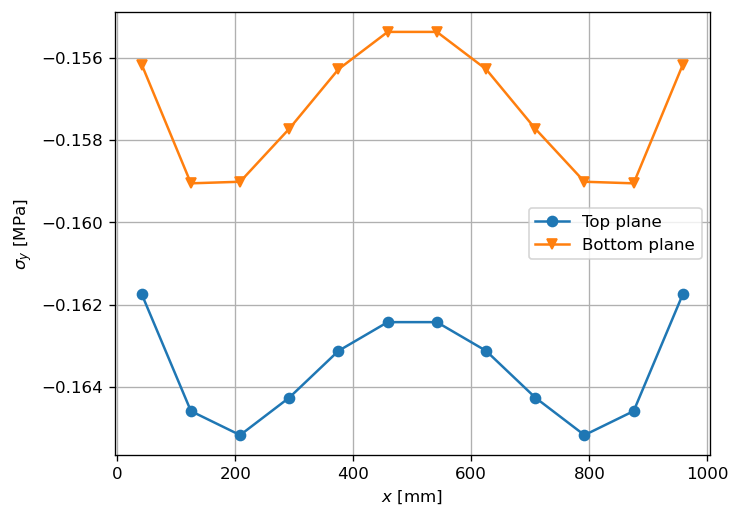

In [14]:
# Find id of the elements located along the prescribed section
stress_profile_y_location = 400  # [mm]
stress_profile_indices = np.where([(np.amin(e[:, 1]) < stress_profile_y_location) &  # lowest y-coordinate of nodes lower than y-coordinate of prescribed section
                                   (np.amax(e[:, 1]) > stress_profile_y_location) &  # largest y-coordinate of nodes larger than y-coordinate of prescribed section 
                                   (all(np.abs(e[:, 2] - h/2) < tolerance))  # all nodes located at z=h/2
                                   for e in elements_nodes_xyz])[0]
stress_profile_element_ids = elements_ids[stress_profile_indices]

# Find stresses data of the elements along the prescribed section
stress_profile_data = np.stack([op2_output.nonlinear_cquad4_stress[subcase_id].data[0, np.where(
    op2_output.nonlinear_cquad4_stress[subcase_id].element == eid)[0][0]*2:
    np.where(op2_output.nonlinear_cquad4_stress[subcase_id].element == eid)[0][0]*2 + 2, :]  # there are two rows in data[0, :, :] for each element, the first row corresponds to the stress and strain values at the bottom plane of the element, the second row to the top plane
      for eid in stress_profile_element_ids], axis=0)  # stress profile data is a ndarray with shape no_stress_profile_elements x 2 (bottom and top plane) x 12 (number of stress and strain data on each plane)

# Find x location of the elements' centroid along the prescribed section
elements_centroid_x = elements_centroid_xyz[stress_profile_indices, 0]

# Plot axial stress vs x coordinate of the element for both the top and bottom plane
_, ax = plt.subplots()
ax.plot(elements_centroid_x, stress_profile_data[:, 0, 2], 'o-', label='Top plane')  # the stress along the y-axis of the element is the third element of the last dimension of the data array
ax.plot(elements_centroid_x, stress_profile_data[:, 1, 2], 'v-', label='Bottom plane')
ax.legend()
plt.xlabel('$x$ [mm]')
plt.ylabel('$\sigma_y$ [MPa]')
plt.grid()
plt.show()

We observe that the stress at the top plane is more negative than the one at the bottom plane, as expected, implying an asymmetry about the midplane of the top skin.

## Reinforced box beam <a name="reinforced"></a>

***

### Setup of the numerical model <a name="reinforced-numerical-model"></a>

We consider the same geometry and material used for the unreinforced box beam and prescribe the same ribs spacing employed in a [previous notebook](08_Nonlinear_Buckling_Analysis_of_a_Reinforced_Box_Beam.ipynb).

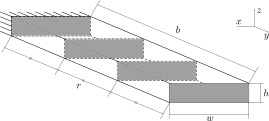

In [15]:
SVG(filename=os.path.join('resources', '08_BoxBeamGeometry.svg'))

In [16]:
ribs_spacing = w/2  # half of box beam's width
no_ribs = int(np.ceil(b/ribs_spacing)) + 1  # calculate number of ribs
ribs_y_locations = np.linspace(0, b, no_ribs)  # calculate y-coordinates of the ribs

# Print information to screen
np.set_printoptions(precision=0)
print(f'Number of ribs: {no_ribs:.0f}')
print(f'Ribs\' y-coordinate [mm]:')
print(ribs_y_locations)

Number of ribs: 10
Ribs' y-coordinate [mm]:
[   0.  500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500.]


We create a mesh of quadrilateral elements using the function `mesh_box_beam_with_pyvista` from the `box_beam_utils` module. We prescribe an edge length of 49 mm based on the results of a previous [mesh convergence study](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb#mesh-convergence).

In [17]:
edge_length = 49  # [mm]
reinforced_box_beam_mesh = box_beam_utils.mesh_box_beam_with_pyvista(ribs_y_coordinates=ribs_y_locations, width=w, height=h, edge_length=edge_length)
nodes_coordinates_array = reinforced_box_beam_mesh.points
nodes_connectivity_matrix = reinforced_box_beam_mesh.faces.reshape(-1, 5)[:, 1:]

We create a base `BDF` object with fixed boundary conditions at the box beam root.

In [18]:
reinforced_box_beam_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
print(reinforced_box_beam_bdf.get_bdf_stats())  # print cards of BDF object

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 7154

bdf.elements: 0
  CQUAD4   : 7368

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Then we apply a concentrated tip load in an analogous way as done for the unreinforced box beam. This time we use a RBE3 element to connect the nodes along the outer edges of the tip section to the node in the center as the rigidity of the tip is enforced by the presence of a physical rib.

In [19]:
# Find outer nodes of tip rib
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tolerance = edge_length/100
outer_tip_nodes_ids = nodes_ids[(np.abs(nodes_coordinates_array[:, 1] - b) < tolerance) & ((nodes_coordinates_array[:, 0] < tolerance) | (np.abs(nodes_coordinates_array[:, 0] - w) < tolerance) | (np.abs(nodes_coordinates_array[:, 2] - h/2) < tolerance) | (np.abs(nodes_coordinates_array[:, 2] + h/2) < tolerance))]  # nodes along the edges of the tip section

# Add master node of tip section
tip_master_node_id = np.amax(nodes_ids) + 1
reinforced_box_beam_bdf.add_grid(tip_master_node_id, [w/2, b, 0.])

# Add RBE3 to connect master node with outer nodes of tip rib
rbe3_eid = len(reinforced_box_beam_bdf.elements) + 1
reinforced_box_beam_bdf.add_rbe3(eid=rbe3_eid, refgrid=tip_master_node_id, refc='123456', weights=[1.]*len(outer_tip_nodes_ids), comps=['123456']*len(outer_tip_nodes_ids), Gijs=outer_tip_nodes_ids)

# Add concentrated force
pynastran_utils.add_unitary_force(bdf_object=reinforced_box_beam_bdf, nodes_ids=[tip_master_node_id], set_id=force_set_id, direction_vector=force_direction)

### Linear buckling analysis <a name="reinforced-linear-buckling"></a>

Once again, we use SOL 105 to calculate the linear buckling load and the corresponding buckling shape.

Nastran job reinforced_box_beam_linear_buckling.bdf completed
Wall time: 4.0 s


Buckling load: 3094 N
Buckling mode:


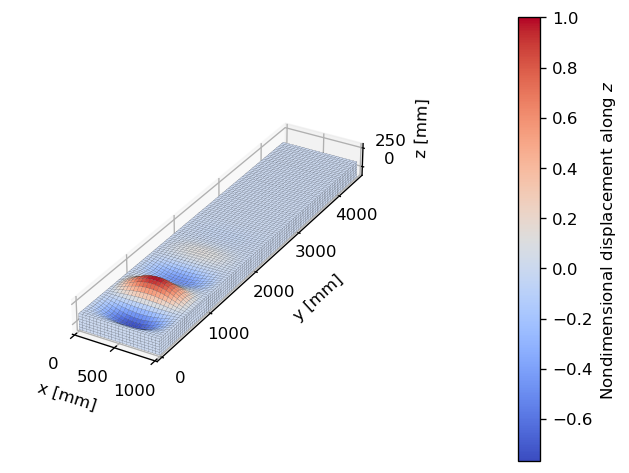

In [20]:
# Run SOL 105 and return OP2 object
input_name = 'reinforced_box_beam_linear_buckling'
sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=reinforced_box_beam_bdf.__deepcopy__({}), static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)  # we pass a deep copy of the BDF object to the function to be able to set up the nonlinear analysis later

# Print critical buckling load and plot mode
sol_105_buckling_load = sol_105_op2.eigenvectors[2].eigr
print(f'Buckling load: {sol_105_buckling_load:.0f} N')
plt.rcParams['figure.dpi'] = 120  # set default dpi of figures
print(f'Buckling mode:')
_, ax = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=2, displacement_component='tz', colormap='coolwarm')
set_ticks_and_labels_position(ax)
plt.show()

### Nonlinear analysis <a name="reinforced-nonlinear-analysis"></a>

We initialize the nonlinear analysis with the arc-length method setting the same parameters used previously and we create a subcase with an applied load equal to twice the linear buckling load.

In [21]:
pynastran_utils.set_up_arc_length_method(bdf_object=reinforced_box_beam_bdf, ninc=100, eps_p=1e-3, eps_w=1e-7, maxalr=1.1, desiter=5, maxinc=100)  # set up nonlinear analysis with arc-length method
reinforced_box_beam_bdf.case_control_deck.subcases[0].add_result_type('NLSTRESS', 'ALL', ['PLOT'])  # store nonlinear stress results of all elements in the op2 file
load_magnitude = sol_105_buckling_load*2  # define applied load magnitude
reinforced_box_beam_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[load_magnitude], load_ids=[force_set_id])  # add LOAD card
pynastran_utils.create_static_load_subcase(bdf_object=reinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=load_set_id)  # create subcase

Let's run the analysis and plot the load-displacement diagram and the final deformation shape.

Nastran job reinforced_box_beam_nonlinear_analysis.bdf completed
Wall time: 84.0 s


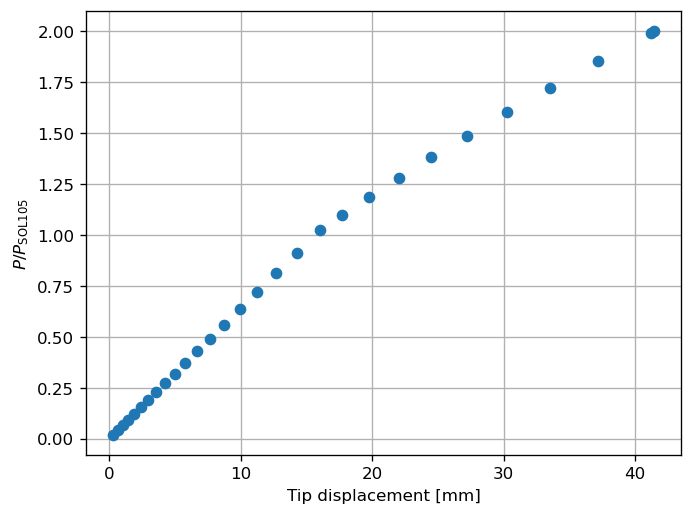

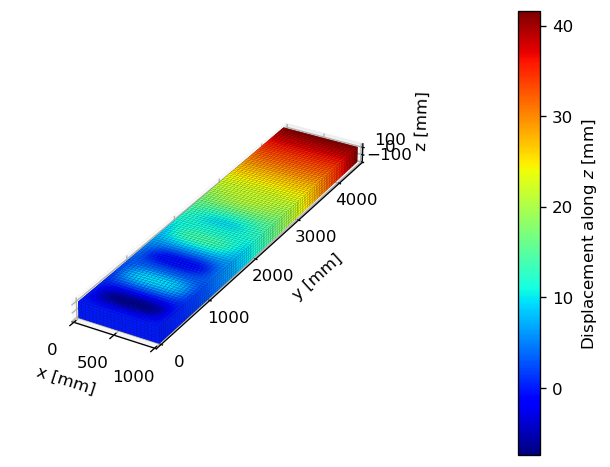

In [22]:
# Run analysis
input_filename = 'reinforced_box_beam_nonlinear_analysis'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=reinforced_box_beam_bdf, filename=input_filename, run_flag=False)

# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)

# Find load and displacement history
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=tip_master_node_id)

# Select translation along z as the load and displacement components to plot
load_component_index = 2
displacement_component_index = 2

# Plot load-displacement diagram
_, ax = plt.subplots()
ax.plot(displacements[1][:,displacement_component_index], loads[1][:, load_component_index]/sol_105_buckling_load, 'o')
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL 105}$')
plt.grid()
plt.show()

# Plot final static deformation
_, ax = pynastran_utils.plot_static_deformation(op2_object=op2_output, subcase_id=subcase_id, displacement_component='tz')
set_ticks_and_labels_position(ax)
plt.show()

Also in this case we observe a change in the slope of the load-displacement diagram approximately at $P/P_\text{SOL 105}=1$ and a buckled-like shape for the final deformation of the structure.

### Stress results <a name="reinforced-stress-results"></a>

Analogously to the unreinforced box beam case, we plot the axial stress $\sigma_y$ along the prescribed section for both the top and bottom plane. We consider again the section at $y=400$ mm.

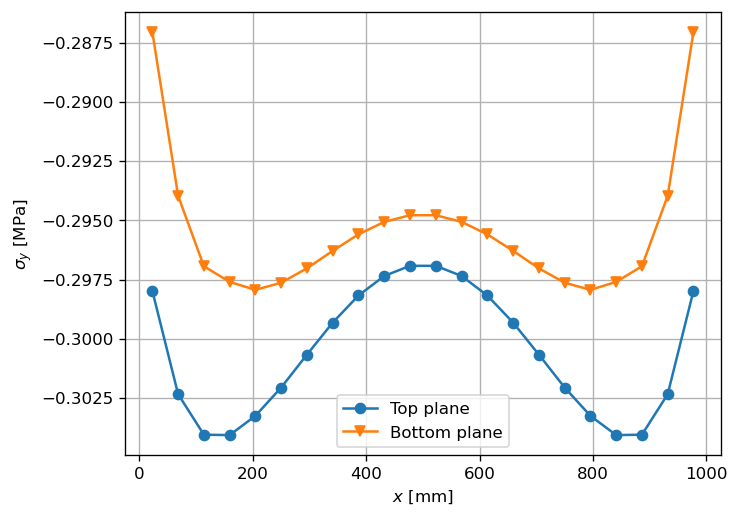

In [23]:
# Find id of the elements located along the prescribed section
elements_nodes_xyz = np.stack([e.get_node_positions() for e in op2_output.elements.values()], axis=0)
elements_centroid_xyz = np.sum(elements_nodes_xyz, axis=1)/4
stress_profile_indices = np.where([(np.amin(e[:, 1]) < stress_profile_y_location) &  # lowest y-coordinate of nodes lower than y-coordinate of prescribed section
                                   (np.amax(e[:, 1]) > stress_profile_y_location) &  # largest y-coordinate of nodes larger than y-coordinate of prescribed section 
                                   (all(np.abs(e[:, 2] - h/2) < tolerance))  # all nodes located at z=h/2
                                   for e in elements_nodes_xyz])[0]
stress_profile_element_ids = elements_ids[stress_profile_indices]

# Find stresses data of the elements along the prescribed section
stress_profile_data = np.stack([op2_output.nonlinear_cquad4_stress[subcase_id].data[0, np.where(
    op2_output.nonlinear_cquad4_stress[subcase_id].element == eid)[0][0]*2:
    np.where(op2_output.nonlinear_cquad4_stress[subcase_id].element == eid)[0][0]*2 + 2, :]  # there are two rows in data[0, :, :] for each element, the first row corresponds to the stress and strain values at the bottom plane of the element, the second row to the top plane
      for eid in stress_profile_element_ids], axis=0)  # stress profile data is a ndarray with shape no_stress_profile_elements x 2 (bottom and top plane) x 12 (number of stress and strain data on each plane)

# Find x location of the elements' centroid along the prescribed section
elements_centroid_x = elements_centroid_xyz[stress_profile_indices, 0]

# Plot axial stress vs x coordinate of the element for both the top and bottom plane
_, ax = plt.subplots()
ax.plot(elements_centroid_x, stress_profile_data[:, 0, 2], 'o-', label='Top plane')
ax.plot(elements_centroid_x, stress_profile_data[:, 1, 2], 'v-', label='Bottom plane')
ax.legend()
plt.xlabel('$x$ [mm]')
plt.ylabel('$\sigma_y$ [MPa]')
plt.grid()
plt.show()

Also in this case the axial stress varies from a more negative value at the top plane to a less negative value at the bottom plane, as expected. Once again this implies an asymmetry of the internal load of the top skin about its midplane.

## Conclusions <a name="conclusions"></a>

***

In this notebook we have demonstrated that the bending load used in previous notebooks introduces an asymmetry in the internal load of the top skin of the box beam. This has been observed for both the unreinforced and the reinforced cases. The results corroborate the hypothesis that the bifurcation break observed in the previous notebooks has a mechanical cause.

In our [next notebook](11_Equilibrium_Diagram_of_a_Box_Beam_Under_Uniaxial_Compression.ipynb) we will seek further proof of the mechanical nature of the bifurcation break investigating the behaviour of the box beam under a pure compression load applied at the center of the tip section. This type of load is not supposed to break any symmetry and as a consequence we expect to observe the bifurcation behavior to be restored.